## Estimating Mutual Information with Generative Adversarial Networks (GAN)

___
$\def\abs#1{\left\lvert #1 \right\rvert}
\def\Set#1{\left\{ #1 \right\}}
\def\mc#1{\mathcal{#1}}
\def\M#1{\boldsymbol{#1}}
\def\R#1{\mathsf{#1}}
\def\RM#1{\boldsymbol{\mathsf{#1}}}
\def\op#1{\operatorname{#1}}
\def\E{\op{E}}
\def\d{\mathrm{\mathstrut d}}$

In last section, we have proved that

$$
\begin{equation}
    I(\R{X}\wedge \R{Y}) = \mathop{\inf}_{p_{\R{X}'},p_{\R{Y}'}} D(p_{\R{X}\R{Y}}||p_{\R{X}'}p_{\R{Y}'}).
\end{equation}
$$

We can further apply the DV variational formulation:

$$
I(\mathsf{X}\wedge \mathsf{Y}) = \mathop{\inf}_{p_{\R{X}'}, p_{\R{Y}'}} \mathop{\sup}_{f\in\mathcal{F}} \left\{E[f(\R{X},\R{Y})]-\log E[e^{f(\R{X}',\R{Y}')}]  \right\}.
$$

We can construct generative models to simulate the sampling process of the variational distributions $p_{\R{X}'},p_{\R{Y}'}$, and then the training of these models represents the density updating process. More precisely, we build two multilayer generative neural networks denoted as $g^1,g^2$, where $g^1$ and $g^2$ are differentiable functions mapping from the Gaussian noise $\R{Z}_1, \R{Z}_2$ to the targets $\R{X}, \R{Y}$, respectively. The samples generated by $g^1,g^2$ can be viewed as drawn from the variational distributions $p_{\R{X}'}$ and $p_{\R{Y}'}$. Therefore, optimizing $p_{\R{X}'},p_{\R{Y}'}$ is equal to train the generative models $g^1,g^2$. 

We apply the **reparametrization trick** with $p_{\R{Z}_1},p_{\R{Z}_2}$, which can provide tractable gradient estimator of GAN-MINEE. With the change of variable rule, we have
\begin{equation}
    p_{\R{Z}_1}(z_1) = p_{\R{X}'}(g^1(z_1))\left|\det \frac{\partial g^1(z_1)}{\partial z_1}\right|.
\end{equation}

Then we can derive that
\begin{align}
    \mathbb{E}[e^{f(\R{X}',\R{Y}')}] 
    = \mathbb{E} [e^{f(g^1(\R{Z}_1),g^2(\R{Z}_2))}],
\end{align}

Then the objective function can be rewritten as 
\begin{equation}
    I(\R{X}\wedge \R{Y}) = \mathop{\inf}_{g^1,g^2} \mathop\sup_{f} \left\{E[f(\R{X},\R{Y})]-\log E\big[e^{f(g^1(\R{Z}_1),g^2(\R{Z}_2))}\big]  \right\}, 
\end{equation}
which is the proposed MI estimator GAN-MINEE. We can train this minimax formulation by optimizing $g^1,g^2$ and $f$ in order iteratively.

In [40]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import argparse
import os
import itertools
from tqdm import tqdm

cuda = True if torch.cuda.is_available() else False
FloatTensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if cuda else torch.LongTensor

In [41]:
def gaussian_data(rho=0.9, mean=[0, 0],sample_size=100):
    cov = np.array([[1, rho], [rho, 1]])
    return np.random.multivariate_normal(
        mean=mean,
        cov=cov,
        size=sample_size)

In [42]:
seed = 0
rep = 1
# use GPU if available
if torch.cuda.is_available():
    torch.set_default_tensor_type(torch.cuda.FloatTensor)
else:
    torch.set_default_tensor_type(torch.FloatTensor)

np.random.seed(seed)
# initialize random seed
torch.manual_seed(seed)
mu1 = 0
mu2 = 0

rho = 0.9           # model parameter
rho2 = -0.9
rep = 1             # number of repeated runs
ref_batch_factor = 10
d = 1
lr = 1e-4
b1, b2 = 0.5, 0.999
sample_size = 400
batch_size = 100
hidden_dim = 100
ma_rate = 0.1
ma_ef= 1
n_iters = 10000
mi = -0.5*np.log(1-rho**2)*d
X = np.zeros((sample_size,d))
Y = np.zeros((sample_size,d))

for j in range(d):
    data = gaussian_data(sample_size=sample_size,rho=rho)
    X[:,j] = data[:,0]
    Y[:,j] = data[:,1]
X = torch.Tensor(X)
Y = torch.Tensor(Y)

In [43]:
def _resample(data, batch_size, replace=False):
    # Resample the given data sample.
    index = np.random.choice(
        range(data.shape[0]), size=batch_size, replace=replace)
    batch = data[index]
    return batch

def _uniform_sample(data, batch_size):
    # Sample the reference uniform distribution
    data_min = data.min(dim=0)[0]
    data_max = data.max(dim=0)[0]
    return (data_max - data_min) * torch.rand((batch_size, data_min.shape[0])) + data_min

def _div(net, data, ref):
    # Calculate the divergence estimate using a neural network
    mean_f = net(data).mean()
    # log_mean_ef_ref = torch.exp(net(ref)-1).mean()
    log_mean_ef_ref = torch.logsumexp(net(ref), 0) - np.log(ref.shape[0])
    return mean_f - log_mean_ef_ref

class Generator(nn.Module):
    def __init__(self,y_dim, sigma=0.02):
        super(Generator, self).__init__()
        input_dim = d
        hidden_size = hidden_dim
        self.fc1 = nn.Linear(input_dim, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, y_dim)
        nn.init.normal_(self.fc1.weight, std=sigma)
        nn.init.constant_(self.fc1.bias, 0)
        nn.init.normal_(self.fc2.weight, std=sigma)
        nn.init.constant_(self.fc2.bias, 0)
        nn.init.normal_(self.fc3.weight, std=sigma)
        nn.init.constant_(self.fc3.bias, 0)

    def forward(self, noise):
        gen_input = noise
        output = F.elu(self.fc1(gen_input))
        output = F.elu(self.fc2(output))
        output = self.fc3(output)
        return output

class Net(nn.Module):
    # Inner class that defines the neural network architecture
    def __init__(self, input_size=2, hidden_size=100, sigma=0.02):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, 1)
        nn.init.normal_(self.fc1.weight, std=sigma)
        nn.init.constant_(self.fc1.bias, 0)
        nn.init.normal_(self.fc2.weight, std=sigma)
        nn.init.constant_(self.fc2.bias, 0)
        nn.init.normal_(self.fc3.weight, std=sigma)
        nn.init.constant_(self.fc3.bias, 0)

    def forward(self, input):
        output = F.elu(self.fc1(input))
        output = F.elu(self.fc2(output))
        output = self.fc3(output)
        return output

In [44]:
# Initialize generator and discriminator
generator1 = Generator(y_dim=d)
generator2 = Generator(y_dim=d)
discriminator = Net(input_size=d*2, hidden_size=100)

if cuda:
    generator1.cuda()
    generator2.cuda()
    discriminator.cuda()
# Optimizers Adam
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))
optimizer_G = torch.optim.Adam(
    itertools.chain(generator1.parameters(), generator2.parameters()), lr=lr, betas=(b1, b2)
)

In [45]:
mi_list = []


for i in tqdm(range(n_iters)):
    z = FloatTensor(np.random.normal(0, 1, (sample_size*ref_batch_factor, d)))

    y_gen = generator1(z)
    x_gen = generator2(z)

    XY = torch.cat((X, Y), dim=1)
    X_ref = _resample(X, batch_size=X.shape[0])
    Y_ref = _resample(Y, batch_size=Y.shape[0])
    y_gen_ref = _resample(y_gen, batch_size=batch_size*ref_batch_factor)
    x_gen_ref = _resample(x_gen, batch_size=batch_size*ref_batch_factor)

    XY_ref = torch.cat((x_gen_ref, y_gen_ref), dim=1)
    batch_XY = _resample(XY, batch_size=batch_size)
    batch_XY_gen_ref = torch.cat((x_gen_ref,y_gen_ref), dim=1)
    # -----------------
    #  Train Generator
    # -----------------
    optimizer_G.zero_grad()
    log_mean_ef_ref = torch.logsumexp(discriminator(batch_XY_gen_ref), 0) - np.log(batch_XY_gen_ref.shape[0])
    gen_loss = -log_mean_ef_ref
    gen_loss.backward()
    optimizer_G.step()

    # ---------------------
    #  Train Discriminator
    # ---------------------
    # define the loss function with moving average in the gradient estimate
    for _ in range(2):
        z = FloatTensor(np.random.normal(0, 1, (sample_size*ref_batch_factor, d)))

        y_gen = generator1(z)
        x_gen = generator2(z)

        XY = torch.cat((X, Y), dim=1)
        X_ref = _resample(X, batch_size=X.shape[0])
        Y_ref = _resample(Y, batch_size=Y.shape[0])
        y_gen_ref = _resample(y_gen, batch_size=batch_size*ref_batch_factor)
        x_gen_ref = _resample(x_gen, batch_size=batch_size*ref_batch_factor)

        XY_ref = torch.cat((x_gen_ref, y_gen_ref), dim=1)
        batch_XY = _resample(XY, batch_size=batch_size)
        batch_XY_gen_ref = torch.cat((x_gen_ref,y_gen_ref), dim=1)

        optimizer_D.zero_grad()
        mean_fXY = discriminator(batch_XY).mean()
        mean_efXY_ref = torch.exp(discriminator(batch_XY_gen_ref)).mean()
        ma_ef = (1-ma_rate)*ma_ef + ma_rate*mean_efXY_ref
        batch_loss_XY = - mean_fXY + (1 / ma_ef).detach() * mean_efXY_ref
        batch_loss_XY.backward()
        optimizer_D.step()

    mi_list.append(_div(discriminator, XY, batch_XY_gen_ref).cpu().item())

# torch.save(discriminator.state_dict(), chkpt_name)

100%|██████████| 10000/10000 [15:40<00:00, 10.63it/s]


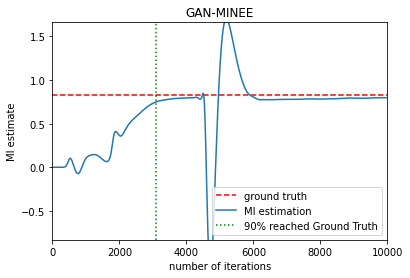

mi 0.8303656034108255


In [48]:
mi_ma_rate = 0.01
mi_array = np.array(mi_list)
for i in range(1,len(mi_array)):
    mi_list[i] = (1-mi_ma_rate) * mi_list[i-1] + mi_ma_rate * mi_list[i]
    
plt.axhline(mi,label='ground truth',linestyle='--',color='red')
plt.plot(mi_list, label='MI estimation')

for t in range(len(mi_array)):
    if (mi_list[t]>.9*mi):
        plt.axvline(t,label='90% reached Ground Truth',linestyle=':',color='green')
        break

plt.xlim((0,n_iters))
plt.ylim((-mi,mi*2))
plt.title('GAN-MINEE')
plt.xlabel("number of iterations")
plt.ylabel("MI estimate")
plt.legend()

plt.show()
print('mi',mi)